In [0]:
#hyper parameters used 

lr_init = 0.001
lr_fine_tuned = 0.00001
batch_sz = 64
dropout_rate = 0.3
image_size = 224

In [0]:
import os
import random
import shutil

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNet 
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras import layers

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -R "drive/My Drive/Small" ./

cp: cannot stat 'drive/My Drive/Small': No such file or directory


In [0]:
!unzip -q "drive/My Drive/small.zip" 

In [0]:
def split_tr_tst(src_dir, tr_dir, tst_dir,tr_split = 0.8):
    items = os.listdir(src_dir)
    #print(items[1])
    random.shuffle(items)
    tst_cnt = round(len(items) * (1-tr_split))
    #print(tst_cnt)
    #print(items[1])
    test_items = items[:tst_cnt]
    train_items = items[tst_cnt:]
    if not(os.path.exists(tst_dir)):
                #print('creating ', dest_dir)
                os.makedirs(tst_dir)
    for item in test_items:
        item_path = os.path.join(src_dir,item)
        dest_path = os.path.join(tst_dir, item)
        shutil.copyfile(item_path,dest_path)
    if not(os.path.exists(tr_dir)):
                #print('creating ', dest_dir)
                os.makedirs(tr_dir)
    for item in train_items:
        item_path = os.path.join(src_dir,item)
        dest_path = os.path.join(tr_dir, item)
        shutil.copyfile(item_path,dest_path)

In [0]:
#all of these folders must exist

base_path = '.'
src = 'small'
tr = 'train'
tst = 'test'

dir_list = os.listdir(os.path.join(base_path,src))

#count the directories inside train dir for the number of category
#will be used to determine the number of classes of the model
num_categories = len(dir_list)



In [0]:
#only run this if there's still no data split between train and test set
for item in dir_list:
  src_dir = os.path.join(base_path,src,item)
  tr_dir = os.path.join(base_path,tr,item)
  tst_dir = os.path.join(base_path,tst,item)
  
  split_tr_tst(src_dir, tr_dir, tst_dir,tr_split = 0.75)


In [0]:
train_dir = os.path.join(base_path,tr)
test_dir = os.path.join(base_path,tst)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(#rescale=1./255)
    preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(image_size, image_size),  
        batch_size=batch_sz,
        class_mode='categorical')

#get dictionary for the label name from the train_generator
class_dict = train_generator.class_indices.items()

# Flow validation images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=batch_sz,
        class_mode='categorical')



Found 1968 images belonging to 6 classes.
Found 656 images belonging to 6 classes.


(64, 224, 224, 3)


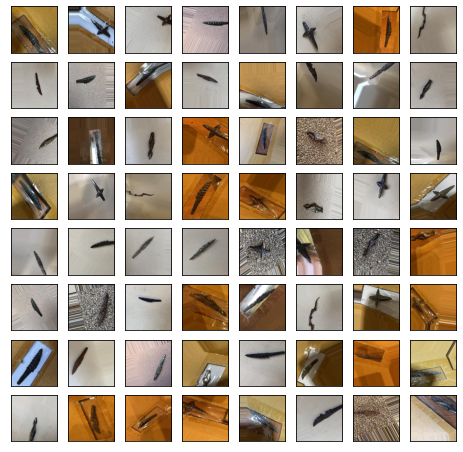

In [0]:
x_batch, y_batch = next(train_generator)
print(x_batch.shape)

fig = plt.figure(figsize=(8,8))

#show only the first 64 samples if batch size is over 64
for i in range(min(batch_sz,64)):
  fig.add_subplot(8, 8, 1 + i, xticks=[], yticks=[])

  #mobileNet preprocessing convert color range to [-1,1]
  #need to change to [0,1] to show color properly
  plt.imshow((x_batch[i]+1)/2)
plt.show()

(64, 224, 224, 3)


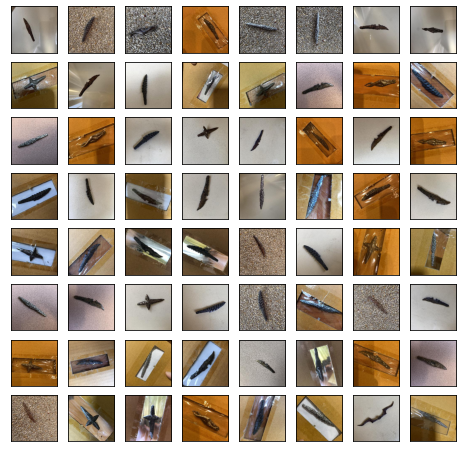

In [0]:
x_batch, y_batch = next(test_generator)

print(x_batch.shape)

fig = plt.figure(figsize=(8,8))

#show only the first 64 samples if batch size is over 64
for i in range(min(batch_sz,64)):
  fig.add_subplot(8, 8, 1 + i, xticks=[], yticks=[])
  #mobileNet preprocessing convert color range to [-1,1]
  #need to change to [0,1] to show color properly
  plt.imshow((x_batch[i]+1)/2)
plt.show()

In [0]:
pretrained_model =  MobileNet(input_shape=(image_size,image_size,3), include_top=False)

#freeze all layers
for layer in pretrained_model.layers:
  layer.trainable = False
  
pretrained_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [0]:
def build_model(base_model, num_categories):

  #get the original output (before its actual top layer) from MobileNet
  org_output = base_model.layers[-1].output

  #the other form for building model in functional style
  #since we cant use the other method to modify pre-built models

  #x represent the output of the model we're modifying
  x = GlobalAveragePooling2D()(org_output)
  x = Dense(1024, activation='relu', name='custom_dense1024')(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(num_categories, activation='softmax', name='output')(x)

  #create a new model from the existing pre-trained model stacking with our layers
  return Model(base_model.input, x)


In [0]:
model = build_model(pretrained_model, num_categories)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=lr_init), 
              metrics=['accuracy'])

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=32,
      epochs=5,
      validation_data=test_generator,
      validation_steps=10,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
32/32 [==============================] - 24s 759ms/step - loss: 1.2499 - accuracy: 0.5812 - val_loss: 0.5071 - val_accuracy: 0.8260
Epoch 2/5
32/32 [==============================] - 24s 749ms/step - loss: 0.5350 - accuracy: 0.8086 - val_loss: 0.3090 - val_accuracy: 0.8818
Epoch 3/5
32/32 [==============================] - 24s 756ms/step - loss: 0.4197 - accuracy: 0.8548 - val_loss: 0.2364 - val_accuracy: 0.9122
Epoch 4/5
32/32 [==============================] - 24s 746ms/step - loss: 0.3498 - accuracy: 0.8740 - val_loss: 0.2360 - val_accuracy: 0.9071
Epoch 5/5
32/32 [==============================] - 24s 748ms/step - loss: 0.3084 - accuracy: 0.8888 - val_loss: 0.2206 - val_accuracy: 0.9037


In [0]:
#save weights and rebuilt the model
#the reason we do this is because we need to re-compile the model
#if we want to change the learning rate
#and it causes out-of-memery error 
#if we do that too many times

model.save_weights('model_weights.hdf5')

#rebuild and re-load weights"
model = build_model(pretrained_model, num_categories)
model.load_weights('model_weights.hdf5')


#unfreeze the layers down to conv_pw_9

reached_conv_pw_9 = False
for layer in model.layers:
    if layer.name == 'conv_pw_9':
        reached_conv_pw_9 = True
    if reached_conv_pw_9:
        layer.trainable = True
        
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=lr_fine_tuned), 
              metrics=['accuracy'])

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=32,
      epochs=20,
      validation_data=test_generator,
      validation_steps=10,
      verbose=1)

Epoch 1/20
32/32 [==============================] - 25s 766ms/step - loss: 0.7789 - accuracy: 0.7505 - val_loss: 0.3133 - val_accuracy: 0.8970
Epoch 2/20
32/32 [==============================] - 24s 751ms/step - loss: 0.4359 - accuracy: 0.8553 - val_loss: 0.3217 - val_accuracy: 0.8902
Epoch 3/20
32/32 [==============================] - 24s 757ms/step - loss: 0.3029 - accuracy: 0.8942 - val_loss: 0.2764 - val_accuracy: 0.8986
Epoch 4/20
32/32 [==============================] - 24s 754ms/step - loss: 0.2795 - accuracy: 0.9001 - val_loss: 0.2242 - val_accuracy: 0.9223
Epoch 5/20
32/32 [==============================] - 24s 759ms/step - loss: 0.2761 - accuracy: 0.9021 - val_loss: 0.2003 - val_accuracy: 0.9257
Epoch 6/20
32/32 [==============================] - 24s 752ms/step - loss: 0.2592 - accuracy: 0.9035 - val_loss: 0.1980 - val_accuracy: 0.9307
Epoch 7/20
32/32 [==============================] - 24s 760ms/step - loss: 0.2475 - accuracy: 0.9129 - val_loss: 0.1696 - val_accuracy: 0.9341

In [0]:
img_path = 'knife-vol5.png'
img = image.load_img(img_path, target_size=(image_size,image_size))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

print(model.predict(x))
print(class_dict)


FileNotFoundError: ignored

In [0]:
model.save('drive/My Drive/meedthi3_ver2.h5')